# Training Data Validation

In [1]:
import pandas as pd

from constants import *
from os.path import join

In [2]:
df_train = pd.read_csv(join(MERGED_DIR, TRAIN_FILE),
                       index_col=DATE_COL,
                       parse_dates=True)
df_train.head()

,X_MSO,Y_MSO,Z_MSO,BX_MSO,BY_MSO,BZ_MSO,DBX_MSO,DBY_MSO,DBZ_MSO,RHO_DIPOLE,...,Z,VX,VY,VZ,VABS,D,COSALPHA,EXTREMA,ORBIT,LABEL
DATE,,,,,,,,,,,,,,,,,,,,,
2011-03-24 07:42:00,6630.097,5739.308,-15373.126,-35.407,15.722,4.999,0.850,0.940,0.386,18120.328019,...,5.817703e+06,-49.256716,-26.708257,2.337419,56.080465,4.882045e+07,0.633532,2,2,0
2011-03-24 07:42:01,6630.372,5739.723,-15372.852,-35.976,14.327,3.401,0.606,0.811,0.729,18120.320315,...,5.817703e+06,-49.256716,-26.708257,2.337456,56.080467,4.882045e+07,0.633532,0,2,0
2011-03-24 07:42:02,6630.645,5740.138,-15372.580,-34.115,17.308,3.078,0.434,0.666,0.367,18120.313647,...,5.817703e+06,-49.256716,-26.708257,2.337478,56.080468,4.882045e+07,0.633532,0,2,0
2011-03-24 07:42:03,6630.920,5740.553,-15372.306,-34.830,17.010,4.846,1.054,1.083,0.505,18120.305979,...,5.817703e+06,-49.256716,-26.708257,2.337449,56.080466,4.882045e+07,0.633532,0,2,0
2011-03-24 07:42:04,6631.195,5740.968,-15372.032,-37.102,14.965,0.640,0.478,0.981,2.181,18120.298328,...,5.817703e+06,-49.256716,-26.708257,2.337420,56.080465,4.882045e+07,0.633532,0,2,0


In [3]:
orbit_ids = df_train[ORBIT_COL].unique()
print(f"#orbits: {len(orbit_ids)}")

#orbits: 3261


At first glance, there appears to be a high deviation in orbit length.

In [4]:
sizes = df_train.groupby(ORBIT_COL).size()
sizes.describe()

count     3261.000000
mean     31383.790555
std       5268.893382
min      27937.000000
25%      28806.000000
50%      28809.000000
75%      29572.000000
max      43466.000000
dtype: float64

The reason for this is that MESSENGER changed from a 12-hour orbit to 8-hour orbit in April 2012.

In [5]:
drop_idx = sizes.diff().abs().idxmax()
drop_day = df_train.index[df_train[ORBIT_COL] == drop_idx][0].strftime("%Y-%m-%d")
print(f"orbit lengths dropped starting with orbit #{drop_idx} on {drop_day}")
sizes.loc[drop_idx-5:drop_idx+5]

orbit lengths dropped starting with orbit #790 on 2012-04-16


ORBIT
785    41778
786    41777
787    41778
788    41777
790    32687
791    32685
792    32686
793    32686
794    32686
795    32686
dtype: int64

When taking this into account, the initial deviation disappears.

In [6]:
sizes.loc[:drop_idx-1].describe()

count      572.000000
mean     42768.372378
std        558.656569
min      41777.000000
25%      42432.000000
50%      42486.500000
75%      43204.000000
max      43466.000000
dtype: float64

In [7]:
sizes.loc[drop_idx:].describe()

count     2689.000000
mean     28962.079583
std        393.923839
min      27937.000000
25%      28805.000000
50%      28808.000000
75%      28813.000000
max      32687.000000
dtype: float64

Verify that no NaN values exist.

In [9]:
nan_count = df_train.isnull().sum().sum()
print(f"There are {nan_count} NaN values.")

There are 0 NaN values.


Sanity-check orbit $42$

LABEL
2   2011-04-13 16:08:39
3   2011-04-13 16:09:41
4   2011-04-13 16:18:45
5   2011-04-13 16:20:17
6   2011-04-13 17:36:30
7   2011-04-13 17:39:36
8   2011-04-13 18:09:43
9   2011-04-13 18:12:19
Name: DATE, dtype: datetime64[ns]


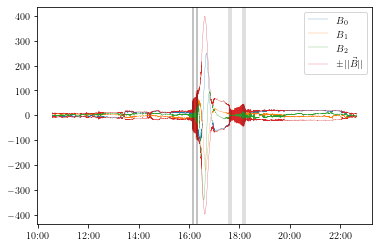

In [10]:
import harry_plotter

orbit = df_train[df_train[ORBIT_COL] == 42]
index = orbit.index
orbit = orbit.reset_index()
vlines = orbit.groupby(orbit[LABEL_COL].diff().ne(0).cumsum()).first().iloc[1:][DATE_COL]
print(vlines)

harry_plotter.plot_components_and_norm(
    index,
    (orbit.BX_MSO,
    orbit.BY_MSO,
    orbit.BZ_MSO),
    symbol="B",
    vlines=vlines
)